In [1]:
from verification.generate_plots import generate_2d, generate_2a, create_balanced_dataset, generate_data_proportion_chart, percentage_dif
from verification.verify_seq import *
from verification.subset import analyze_embeddings, save_top_stories, merge_top_stories, determine_bin, make_large_subset, make_proportional_subset_using_other_subset
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import torch
import gc
import os
torch.mps.empty_cache()

/Users/aidangoeschel/Documents/UCI/CCNL/SemanticAnalysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/aidangoeschel/Documents/UCI/CCNL/SemanticAnalysis/.venv/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


mps is used.


In [2]:
history = 9

model = SequentialityModel("meta-llama/Llama-3.2-3B-Instruct",  # CHANGE THIS
                        topic="A short story",
                        recall_length=history)

data = pd.read_csv("./datasets/syntehtic-stories-gemini.csv")

output = pd.DataFrame(columns=["story", "topic", "temperature", "sequentiality"])

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


In [3]:
for row in tqdm(data.iterrows()):
        story = row[1]["story"]
        topic = row[1]["topic"]
        seq = model.calculate_text_sequentiality(story, topic=topic)

        temperature = row[1]["temperature"]
        output = pd.concat([output, pd.DataFrame({"story": [story], "topic": topic, "temperature": row[1]["temperature"], "sequentiality": [seq[0]]})], ignore_index=True)

0it [00:00, ?it/s]/var/folders/k_/22wd5tt52nqbzmr9k7yzq1xm0000gn/T/ipykernel_29019/2558498075.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat([output, pd.DataFrame({"story": [story], "topic": topic, "temperature": row[1]["temperature"], "sequentiality": [seq[0]]})], ignore_index=True)
200it [00:59,  3.35it/s]


In [4]:
output.describe()

,temperature,sequentiality
count,200.000000,200.000000
mean,0.525000,-0.026117
std,0.289038,0.117753
min,0.050000,-0.471049
25%,0.287500,-0.089551
50%,0.525000,-0.010742
75%,0.762500,0.047852
max,1.000000,0.193902


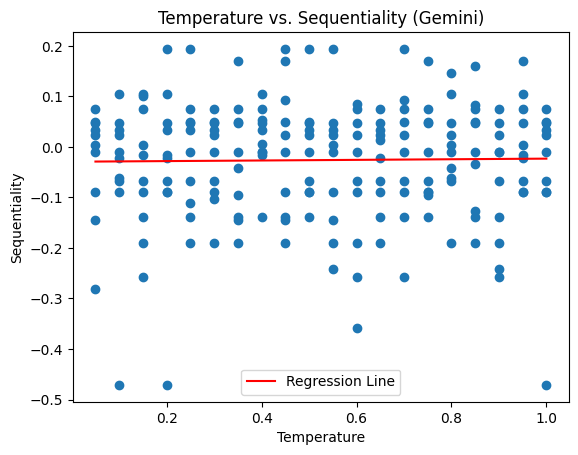

slope: 0.0060733056118080575


In [7]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# Flatten the lists
temps_flat = list(itertools.chain.from_iterable(
    x if isinstance(x, list) else [x] for x in output["temperature"]
))
seq_flat = list(itertools.chain.from_iterable(
    x if isinstance(x, list) else [x] for x in output["sequentiality"]
))

# Convert to numpy arrays
temps_arr = np.array(temps_flat)
seq_arr = np.array(seq_flat)

# Fit regression line
m, b = np.polyfit(temps_arr, seq_arr, 1)
regression_line_y = m * temps_arr + b

# Plot
plt.scatter(temps_arr, seq_arr)
plt.plot(temps_arr, regression_line_y, color='red', label='Regression Line')
plt.title("Temperature vs. Sequentiality (Gemini)")
plt.xlabel("Temperature")
plt.ylabel("Sequentiality")
plt.legend()
plt.show()

print(f"slope: {m}")


In [8]:
from scipy.stats import pearsonr

r, p_val = pearsonr(temps_arr, seq_arr)
print(f"Pearson correlation coefficient: {r:.4f}")
print(f"p-value: {p_val:.4e}")


Pearson correlation coefficient: 0.0149
p-value: 8.3405e-01


In [18]:
# Find the row with the highest sequentiality
max_idx = output["sequentiality"].idxmax()
print("Story with highest sequentiality:")
print(output.loc[max_idx, "story"])
print(f"topic: {output.loc[max_idx, "topic"]}")
print("\nSequentiality:", output.loc[max_idx, "sequentiality"])

# Find the row with the lowest sequentiality
min_idx = output["sequentiality"].idxmin()
print("\nStory with lowest sequentiality:")
print(output.loc[min_idx, "story"])
print(f"topic: {output.loc[min_idx, "topic"]}")
print("\nSequentiality:", output.loc[min_idx, "sequentiality"])

Story with highest sequentiality:
The morning sun filtered through the kitchen window as Clara sipped her coffee, her eyes catching the glint of an envelope peeking from the pile of mail. She frowned, noticing it bore no return address or name, just a simple "To You" scrawled in elegant handwriting. Curiosity tinged with unease gnawed at her as she carefully tore it open.

Inside, she found a single sheet of paper with a message: "Today, you will find a treasure. Look where you least expect." Heart racing, she scanned her modest home. The attic? The garage? The backyard? Each location felt like an empty promise. 

After a moment's hesitation, she decided to check the old oak tree in her front yard, where she used to play as a child. As she dug through the roots, her fingers brushed against something cold and hard. Pulling it free, she uncovered a small, ornate box. 

Inside lay a collection of vintage coins and a note that simply read, "Sometimes, the journey is the treasure." Clara sm

<BarContainer object of 2 artists>

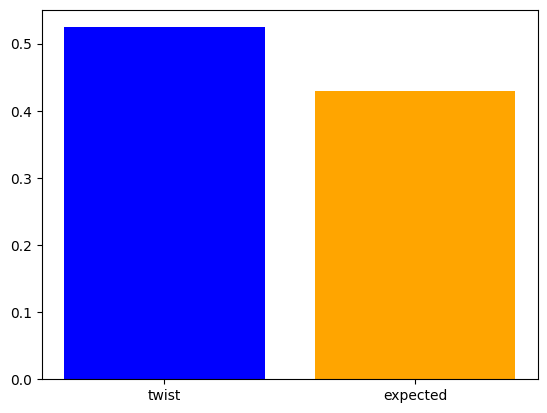

In [4]:
story = """Marcus woke before sunrise, brewed his coffee, and read the news at the kitchen counter. The day followed its usual pattern—he dressed carefully, drove to work through familiar traffic, and spent hours answering emails and attending meetings. At lunch, he ate alone in his car, watching the leaves rustle outside. After work, he returned home, fed the cat, and reheated leftover soup for dinner. The evening was quiet, and though he felt tired, he kept his appointment with the doctor. In the sterile room, the doctor’s calm voice broke the silence with a single word: cancer. Marcus sat still, absorbing the weight of it as darkness settled outside the window."""

seq1 = model.calculate_text_sequentiality(story, topic="A short story about a man named Marcus")
seq2 = model.calculate_text_sequentiality(story, topic="A short story about a man named Marcus who finds out he has cancer")

plt.bar(["twist", "expected"], [seq1[0], seq2[0]], color=['blue', 'orange'])

In [4]:
sentences = [""""THE BOYFRIEND"  in bold white text fades in on a black screen before fading out """,
"""The letters of "high maintenance" appear in the center of the screen one by one in white text. A simple jingle plays in the background""",
"""View of the back of a man's head. He's sitting at a table across from a woman and eating dinner. The woman looks at the man""",
"""View of the man over the woman's shoulder. He's looking down at his plate and cutting something with his knife and fork""",
"""Close up of the woman's face. She's looking down and chewing something""",
"""Close up of the man's face. He's also looking down and chewing""",
"""Side view of the woman's face. She uses her fork to eat something before looking up""",
"""Side view of the man's face. He eats a bite while looking down""",
"""The woman stands up and grabs a bottle of wine to her side. She walks over to the man """,
"""The woman begins to pour wine for the man, but he covers his glass with his hand""",
"""The man, without looking up says "not for me dear" and continues eating""",
"""The woman sits back down and glances at the man before saying "you know it's our anniversary\"""",
"""The man stops eating and looks at the woman, saying "you know I can't drink wine or alcohol" before starting to eat again""",
"""The woman picks up her wine glass and downs it in a few gulps while looking at the man. When she finishes, she sighs and looks at the man pointedly. """,
"""The woman sets down her wine glass with a "clink" sound. She smiles, sighs and then pours more wine for herself. """,
"""The man says "the asparagus is very tender\"""",
"""The woman replies "oh yeah". The man continues to eat without looking up""",
"""Side view of the woman's face. She says "They say it's an aphrodisiac" while looking at the man""",
"""Side view of the man's face. He looks up and asks "Who does?\"""",
"""The woman replies "Oh, I don't know. People. That's just what people say" while eating another bite of food""",
"""The man continues to look down and not say anything. The woman glances up at the man but doesn't say anything""",
"""The man looks up and says "So dear, how was your day?\"""",
"""The woman, furious, gets up and says "Oh geez. Shut up and have a drink!" as she throws her glass of wine at the man. """,
"""The woman sits down, agitated and says "You're a computer analyst, not a fucking surgeon! Why can't you, I don't know, relax for once in your life?!" """,
"""The man takes something out of his pocket""",
"""The woman says angrily "Oh don't you dare\"""",
"""The man, with wine still on his face puts a cigarette in his mouth and starts to smoke. The woman stands up and says "Don't you dare smoke in my house!\"""",
"""The man starts to smoke but the woman storms over and pulls the cigarette out of his mouth. """,
"""The woman walks back across the room and angrily  puts the cigarette out in an ashtray""",
"""The woman looks back across the room to see that the man is lighting another cigarette""",
"""The woman sits down and says, frustrated, "Yeah, that's right. Passive smoke. That's, exactly what I wanted for my anniversary". The man continues to look down and smoke""",
"""The woman continues, "followed by some stilted conversation. And if I'm reallylucky, by some short, mechanical sex." """,
"""The man looks up at the woman""",
"""The woman looks down, avoiding eye contact for a moment but glances up """,
"""The man continues to stare at the woman. He swallows""",
"""The woman looks back before saying…""",
"""The woman says "I'm sorry." and begins to stand up""",
"""The woman walks across the room to the man, and says "Come here\"""",
"""The woman sits down in the man's lap and hugs him, saying "There, there. I didn't mean what I said". """,
"""The woman holds the man's head closer, stroking his hair. """,
"""The woman's hand traces the man's head to his neck. She pulls down the man's shirt collar to reveal a switch on his neck. """,
"""Close up of the woman's face. She blinks""",
"""The woman's hand slides to the switch. She pushes it down with a "click" sound""",
"""Close up of the man's face. With a whine sound, his neck droops and he lies on the woman's shoulder, seemingly unconscious """,
"""The woman pushes the man off her shoulder with a grunt, stands up, and walks away. His head hangs there, limp""",
"""The woman sits down at the other side of the table. She takes off her shoes and crosses her legs on the table, sighing. She says sarcastically "Happy anniversary" """,
"""Close up of the back of a laptop. The camera pans up to the woman, typing something. Metallophone music starts playing in the background""",
"""On her computer screen: "PROMETEUS ROBOTICS CHOOSE EVERLASTING LOVE". With a click, the screen displays a lineup of six differently dressed men. """,
"""The woman types something before looking up""",
"""Across the room, the man still sits there, his head down, hanging limply""",
"""The woman looks back down at her screen before smiling""",
"""On her screen: several pictures of a muscular, dark haired man. """,
"""The woman puts on a bluetooth headset before looking down at her screen again""",
"""Screen briefly shows the same page with the man, before switching to a screen that says "… DIALING: 0800 800 800 … " Sounds of a phone being dialed in the background""",
"""Close up of the woman's face. A woman on the other end of the phone says "Hello you've reached Rachelite (?) technical support, how may I help you?" The woman replies: "Hi. I, I'm unsatisfied with my current unit" The customer support rep says "Okay, what model do you currently have?\"""",
"""The camera pans from the computer screen to a picture frame of the woman in a wedding dress hugging the man. Woman: "It's the 100 series" Customer service: "And what seems to be the problem?\"""",
"""Close up of the woman's face. Woman: "He lacks ambition. He has no sense of adventure." Customer service representative: "Yes, that is a common malfunction with the 100 series.""",
"""The customer service rep continues, "Would it help if we upgraded you to a higher model?" Woman: "Yeah,would you be able to ... \"""",
"""Camera cuts to a view of the man sitting there, still limp. The woman continues "… give me something """,
"""Camera cuts back to a view of the woman. She continues, "a bit sportier?" Customer service rep: "Certainly. Do you have any preferences?" Woman: "Oh, um…" as she clicks the computer""",
"""View of the computer screen, showing the same man. Woman: "A rock climber. Oh no, a masseuse\"""",
"""Camera slowly pans away from the woman at her computer. Woman: "Oh wait. A rock climbing masseuse? Yeah, like the picture. Yeah, but no beard. Maybe just a 5 o'clock shadow. Yeah. And, could he have shorter hair? And blonde. Yeah. And… " """,
"""The camera fades to black""",
"""A loud banging sound on the black screen. Sudden cut to a view of a doorbell. The woman's eye approaches the doorbell.""",
"""A clicking sound as the door unlocks. The woman opens up the door to a delivery girl looking down at her clipboard. A large box that says "Prometeus Robotics…" is pushed into frame, and another delivery girl steps into frame""",
"""Someone walks across frame to reveal a  layer of plastic. Sound of wrinkling plastic as it is pulled away """,
"""Close up of the woman's face. She blinks, and the sound of wrinkling plastic continues""",
"""The delivery woman peels back the plastic to reveal a man, exactly as the woman described earlier. """,
"""Camera slowly zooms in on the woman's face. She looks intensely ahead. A delivery woman walks behind her. String music swells in the background. """,
"""The woman turns her head to see…""",
"""The delivery women have tied the original man to a cart and start to wheel him away """,
"""Camera pans out from the woman's face as she looks at the original man. The new man is in the background, still partially wrapped in plastic""",
"""The woman starts walking over to the original man and the delivery women and says "Um wait please\"""",
"""The woman gives the original man a quick kiss before backing away""",
"""Close up of the woman's hands as she takes a ring off of the original man's ringfinger""",
"""Close up of the woman's hands as she puts the ring on the new man's ringfinger. She sets the man's hand down and pats it gently""",
"""Close up of the woman's hands on the man's neck. She flicks the switch with a click, and an electronic whine starts """,
"""The whine continues. The woman walks across the frame and the man sits there motionless""",
"""The woman sits down and looks expectantly at the man""",
"""The man blinks. With an electronic whine, he looks around. He then grabs the napkin next to him and sits up""",
"""The woman asks cautiously "Glass of wine?" and looks at the man""",
"""The man, looking down, replies "No thanks, I've got a big climb tomorrow as he eats a bite of food. """,
"""The woman looks back before looking down again""",
"""The man looks at the woman and says "the asparagus is very tender\"""",
"""The woman looks back hesitantly before smiling, nodding and saying "Yes, dear\"""",
"""Back to the man, who says "They say it's an aphrodisiac, you know?" while eating a piece""",
"""The woman, smiling, asks "Who does?\"""",
"""The man, shaking his head and smiling slightly says "I don't know, it's just what people say" before standing up""",
"""The man slowly walks across the room until he's behind the woman""",
"""The man starts to massage the woman's shoulders. He says, "So, tell me about your day dear\"""",
"""The woman says "Oh, I went into town this morning to pick up some stuff for tonight.\"""",
"""The man looks down while continuing to massage her""",
"""The woman continues, "then um, I went for light lunch with Anna\"""",
"""Close up of the man's hands. He says "Hm? Then what?\"""",
"""Back to the woman, who, chuckling, says "Um, and then I decided…\"""",
"""Close up of the man's hands. His hands move up her shoulders. The woman continues, "since it's our anniversary, to\"""",
"""The man's left hand moves up to the woman's neck. Woman: "… treat myself and I …\"""",
"""With a click sound, the woman suddenly stops talking""",
"""The woman's neck goes limp and her head hangs""",
"""The man looks up and smiles slightly before walking away""",
"""View of the woman's face hanging there, expressionless. The man walks away""",
"""View of the woman's neck, revealing a switch. """,
"""Camera pans up. In the background the man walks across the room and sits down on a sofa with a cigarette and turns on the TV, crossing his legs""",
"""Close up of th eman's emotionless face as he smokes, with the TV going in the background. """]

In [5]:
import numpy as np

sentence_lens = [len(s.split(".")) for s in sentences]
np.mean(sentence_lens), np.std(sentence_lens)

(1.9423076923076923, 1.1504758470112324)

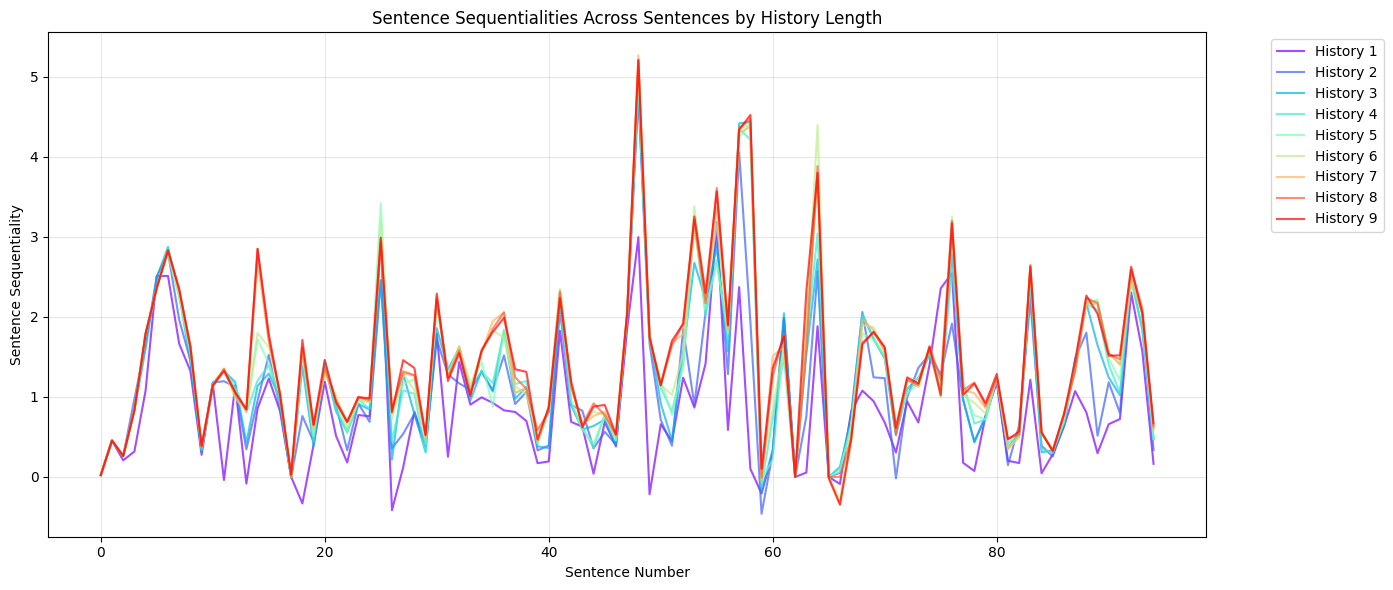

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

# Read the CSV
df = pd.read_csv('outputs/OLMo/film-fest.csv')

# Parse the sentence sequentiality lists
df['seq_list'] = df['sentence_total_sequentialities'].apply(ast.literal_eval)

# Create rainbow colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(df)))

# Plot
plt.figure(figsize=(14, 6))
for idx, row in df.iterrows():
    seq_values = row['seq_list']
    plt.plot(range(len(seq_values)), seq_values, 
             color=colors[idx], label=f'History {idx + 1}', alpha=0.7)

plt.xlabel('Sentence Number')
plt.ylabel('Sentence Sequentiality')
plt.title('Sentence Sequentialities Across Sentences by History Length')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

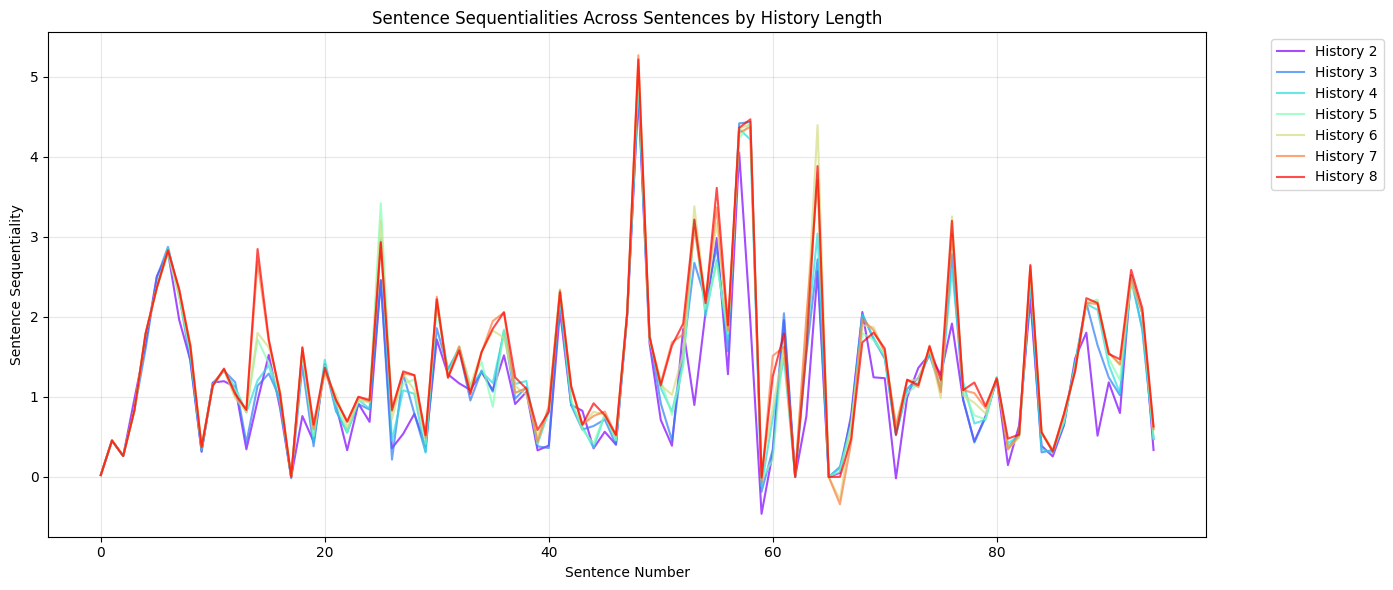

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

df = pd.read_csv('outputs/OLMo/film-fest.csv')
df = df[df.iloc[:, 0].between(1, 7)]  # Filter to history 1-7
df['seq_list'] = df.iloc[:, 2].apply(ast.literal_eval)

colors = plt.cm.rainbow(np.linspace(0, 1, 7))

plt.figure(figsize=(14, 6))
for idx, (_, row) in enumerate(df.iterrows()):
    plt.plot(range(len(row['seq_list'])), row['seq_list'], 
             color=colors[idx], label=f'History {idx+2}', alpha=0.7)

plt.xlabel('Sentence Number')
plt.ylabel('Sentence Sequentiality')
plt.title('Sentence Sequentialities Across Sentences by History Length')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

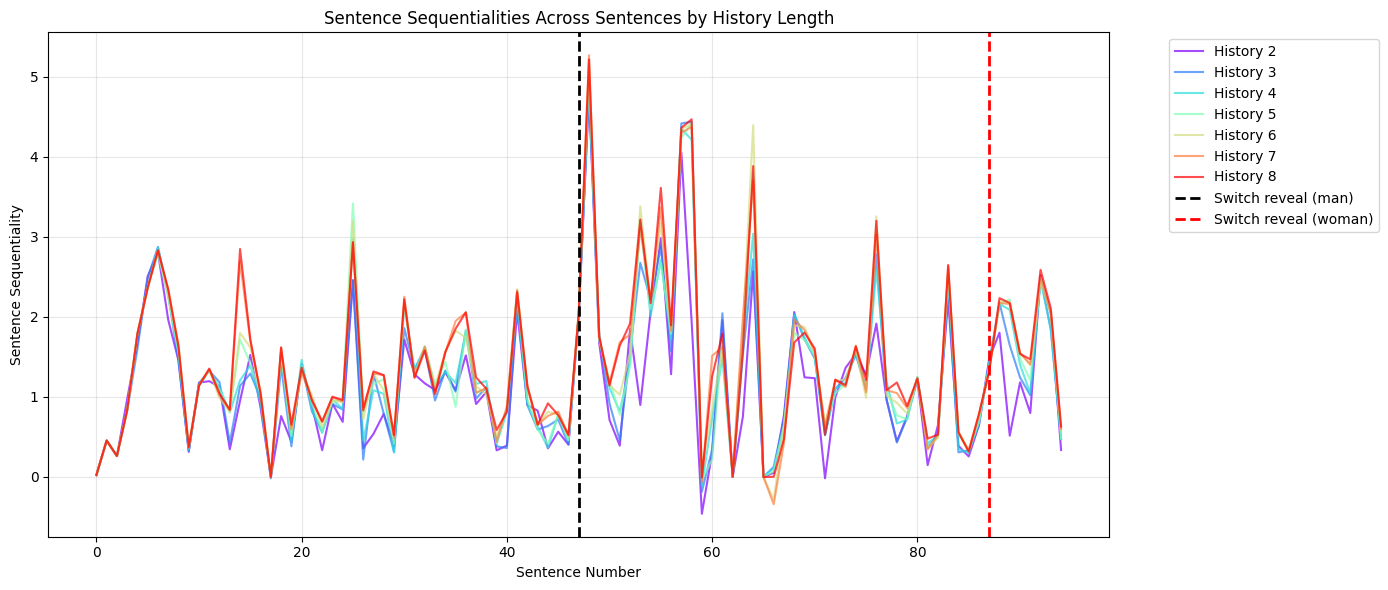

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

df = pd.read_csv('outputs/OLMo/film-fest.csv')
df = df[df.iloc[:, 0].between(1, 7)]
df['seq_list'] = df.iloc[:, 2].apply(ast.literal_eval)

colors = plt.cm.rainbow(np.linspace(0, 1, 7))

plt.figure(figsize=(14, 6))
for idx, (_, row) in enumerate(df.iterrows()):
    plt.plot(range(len(row['seq_list'])), row['seq_list'], 
             color=colors[idx], label=f'History {idx+2}', alpha=0.7)

# Add vertical lines for key plot points
plt.axvline(x=47, color='black', linestyle='--', linewidth=2, label='Switch reveal (man)')
plt.axvline(x=87, color='red', linestyle='--', linewidth=2, label='Switch reveal (woman)')

plt.xlabel('Sentence Number')
plt.ylabel('Sentence Sequentiality')
plt.title('Sentence Sequentialities Across Sentences by History Length')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Minimum sequentiality at sentence index: 59, value: -0.46015625
Sentence: Yeah, but no beard


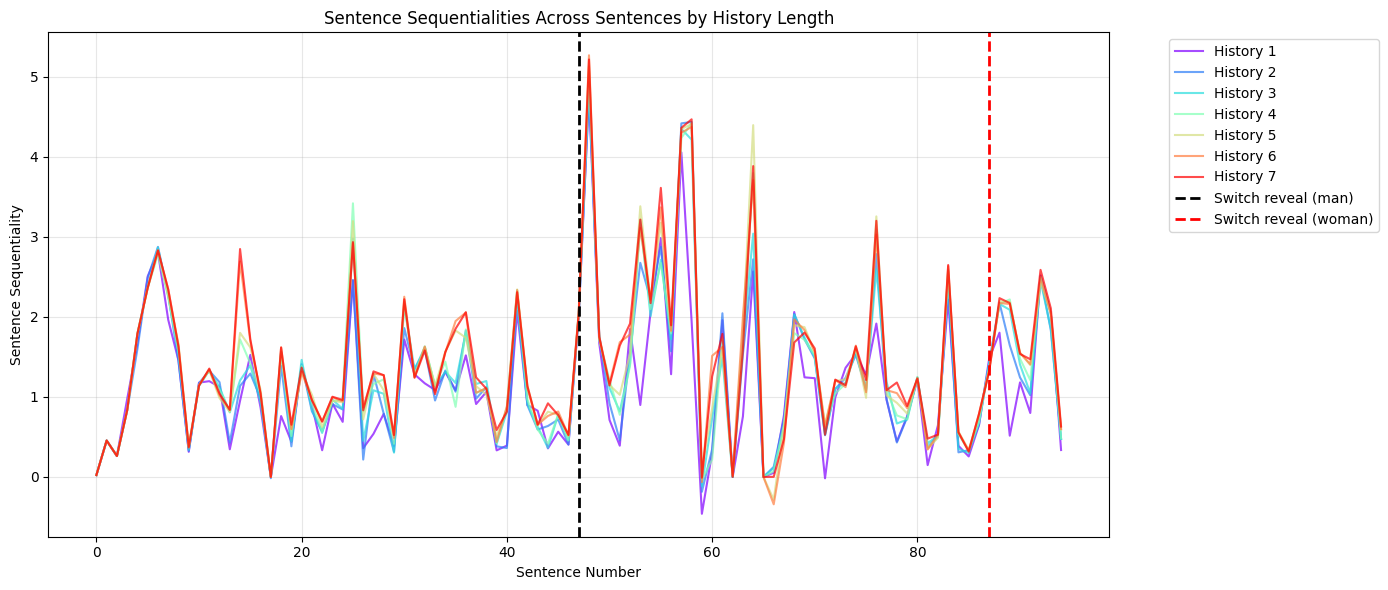

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

df = pd.read_csv('outputs/OLMo/film-fest.csv')
df = df[df.iloc[:, 0].between(1, 7)]
df['seq_list'] = df.iloc[:, 2].apply(ast.literal_eval)

# Find minimum sequentiality across all histories
min_idx = None
min_val = float('inf')
for _, row in df.iterrows():
    seq_list = row['seq_list']
    local_min_idx = np.argmin(seq_list)
    if seq_list[local_min_idx] < min_val:
        min_val = seq_list[local_min_idx]
        min_idx = local_min_idx

# Get the sentence text
story = df.iloc[0]['story']
sentences = [s.strip() for s in story.split('. ') if s.strip()]
min_sentence = sentences[min_idx] if min_idx < len(sentences) else "Sentence not found"

print(f"Minimum sequentiality at sentence index: {min_idx}, value: {min_val}")
print(f"Sentence: {min_sentence}")

colors = plt.cm.rainbow(np.linspace(0, 1, 7))

plt.figure(figsize=(14, 6))
for idx, (_, row) in enumerate(df.iterrows()):
    plt.plot(range(len(row['seq_list'])), row['seq_list'], 
             color=colors[idx], label=f'History {idx+1}', alpha=0.7)

plt.axvline(x=47, color='black', linestyle='--', linewidth=2, label='Switch reveal (man)')
plt.axvline(x=87, color='red', linestyle='--', linewidth=2, label='Switch reveal (woman)')

plt.xlabel('Sentence Number')
plt.ylabel('Sentence Sequentiality')
plt.title('Sentence Sequentialities Across Sentences by History Length')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
import numpy as np
import ast

df = df[df.iloc[:, 0].between(1, 7)]
df['seq_list'] = df.iloc[:, 2].apply(ast.literal_eval)

# Get the story sentences
story = df.iloc[0]['story']
sentences = [s.strip() for s in story.split('. ') if s.strip()]

# Find all sentences with sequentiality <= 0 across all histories
print("Sentences with sequentiality <= 0:\n")
for hist_idx, (_, row) in enumerate(df.iterrows(), start=1):
    seq_list = row['seq_list']
    low_seq_indices = [i for i, val in enumerate(seq_list) if val <= 0]
    
    if low_seq_indices:
        print(f"\n=== History {hist_idx} ===")
        for idx in low_seq_indices:
            sentence = sentences[idx] if idx < len(sentences) else "Sentence not found"
            print(f"Index {idx} (value: {seq_list[idx]:.4f}): {sentence}")

Sentences with sequentiality <= 0:


=== History 1 ===
Index 17 (value: -0.0000): People
Index 59 (value: -0.4602): Yeah, but no beard
Index 62 (value: -0.0000): And, could he have shorter hair? And blonde
Index 65 (value: -0.0000): Sudden cut to a view of a doorbell
Index 71 (value: -0.0168): She blinks, and the sound of wrinkling plastic continues The delivery woman peels back the plastic to reveal a man, exactly as the woman described earlier

=== History 2 ===
Index 17 (value: -0.0156): People
Index 59 (value: -0.1852): Yeah, but no beard
Index 62 (value: -0.0000): And, could he have shorter hair? And blonde
Index 65 (value: -0.0000): Sudden cut to a view of a doorbell

=== History 3 ===
Index 17 (value: -0.0000): People
Index 59 (value: -0.1148): Yeah, but no beard
Index 62 (value: -0.0000): And, could he have shorter hair? And blonde
Index 65 (value: -0.0000): Sudden cut to a view of a doorbell

=== History 4 ===
Index 17 (value: -0.0000): People
Index 59 (value: -0.0320): Yeah, 

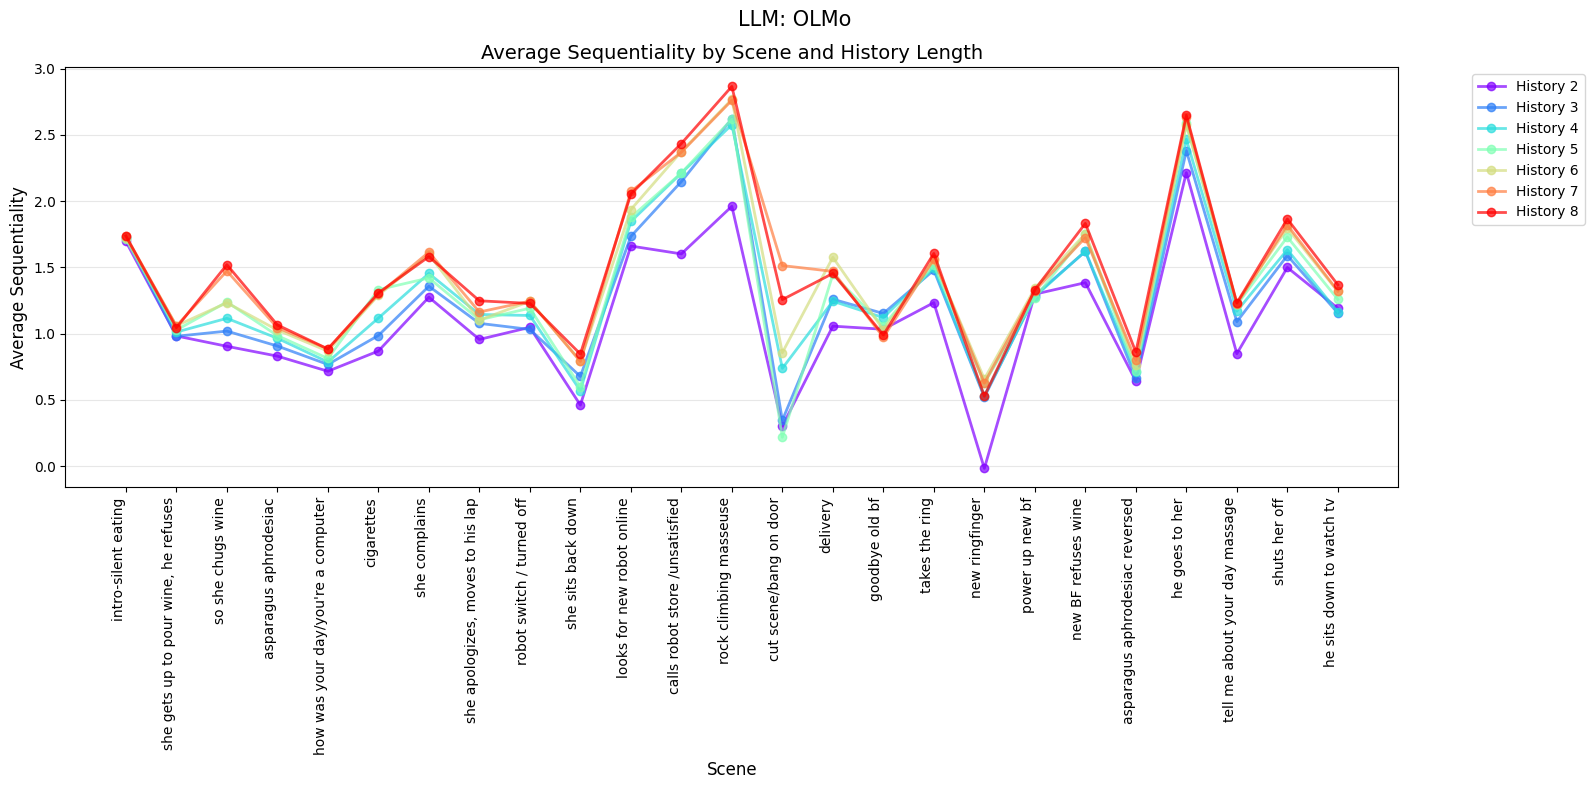

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# Define scene mappings
scene_mapping = {
    'intro-silent eating': list(range(2, 8)),
    'she gets up to pour wine, he refuses': list(range(8, 11)),
    'so she chugs wine': list(range(11, 15)),
    'asparagus aphrodesiac': list(range(15, 21)),
    'how was your day/you\'re a computer': list(range(21, 24)),
    'cigarettes': list(range(24, 30)),
    'she complains': list(range(30, 36)),
    'she apologizes, moves to his lap': list(range(36, 40)),
    'robot switch / turned off': list(range(40, 44)),
    'she sits back down': list(range(44, 46)),
    'looks for new robot online': list(range(46, 52)),
    'calls robot store /unsatisfied': list(range(52, 55)),
    'rock climbing masseuse': list(range(55, 60)),
    'cut scene/bang on door': [60],
    'delivery': list(range(61, 66)),
    'goodbye old bf': list(range(66, 70)),
    'takes the ring': [70],
    'new ringfinger': [71],
    'power up new bf': list(range(72, 75)),
    'new BF refuses wine': list(range(75, 78)),
    'asparagus aphrodesiac reversed': list(range(78, 83)),
    'he goes to her': [83],
    'tell me about your day massage': list(range(84, 90)),
    'shuts her off': list(range(90, 93)),
    'he sits down to watch tv': list(range(93, 95))
}

# Read the data
df = pd.read_csv('outputs/OLMo/film-fest.csv')
df = df[df.iloc[:, 0].between(1, 7)]
df['seq_list'] = df.iloc[:, 2].apply(ast.literal_eval)

# Compute averages for each scene
scene_names = list(scene_mapping.keys())
colors = plt.cm.rainbow(np.linspace(0, 1, 7))

plt.figure(figsize=(16, 8))

llm1_scene_avgs = []

for hist_idx, (_, row) in enumerate(df.iterrows()):
    seq_list = row['seq_list']
    scene_avgs = []
    
    for scene_name in scene_names:
        sentence_indices = scene_mapping[scene_name]
        values = [seq_list[i] for i in sentence_indices if i < len(seq_list)]
        scene_avgs.append(np.mean(values) if values else 0)

    llm1_scene_avgs.append(scene_avgs)
    
    plt.plot(range(len(scene_names)), scene_avgs, 
             color=colors[hist_idx], label=f'History {hist_idx+2}', 
             marker='o', alpha=0.7, linewidth=2)

plt.xlabel('Scene', fontsize=12)
plt.ylabel('Average Sequentiality', fontsize=12)
plt.title('Average Sequentiality by Scene and History Length', fontsize=14)
plt.suptitle('LLM: OLMo', fontsize=15)
plt.xticks(range(len(scene_names)), scene_names, rotation=90, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Run locally with much smaller model

semantic similarity for USE vectors in sliding window 

kl divergence between that and sequentiality

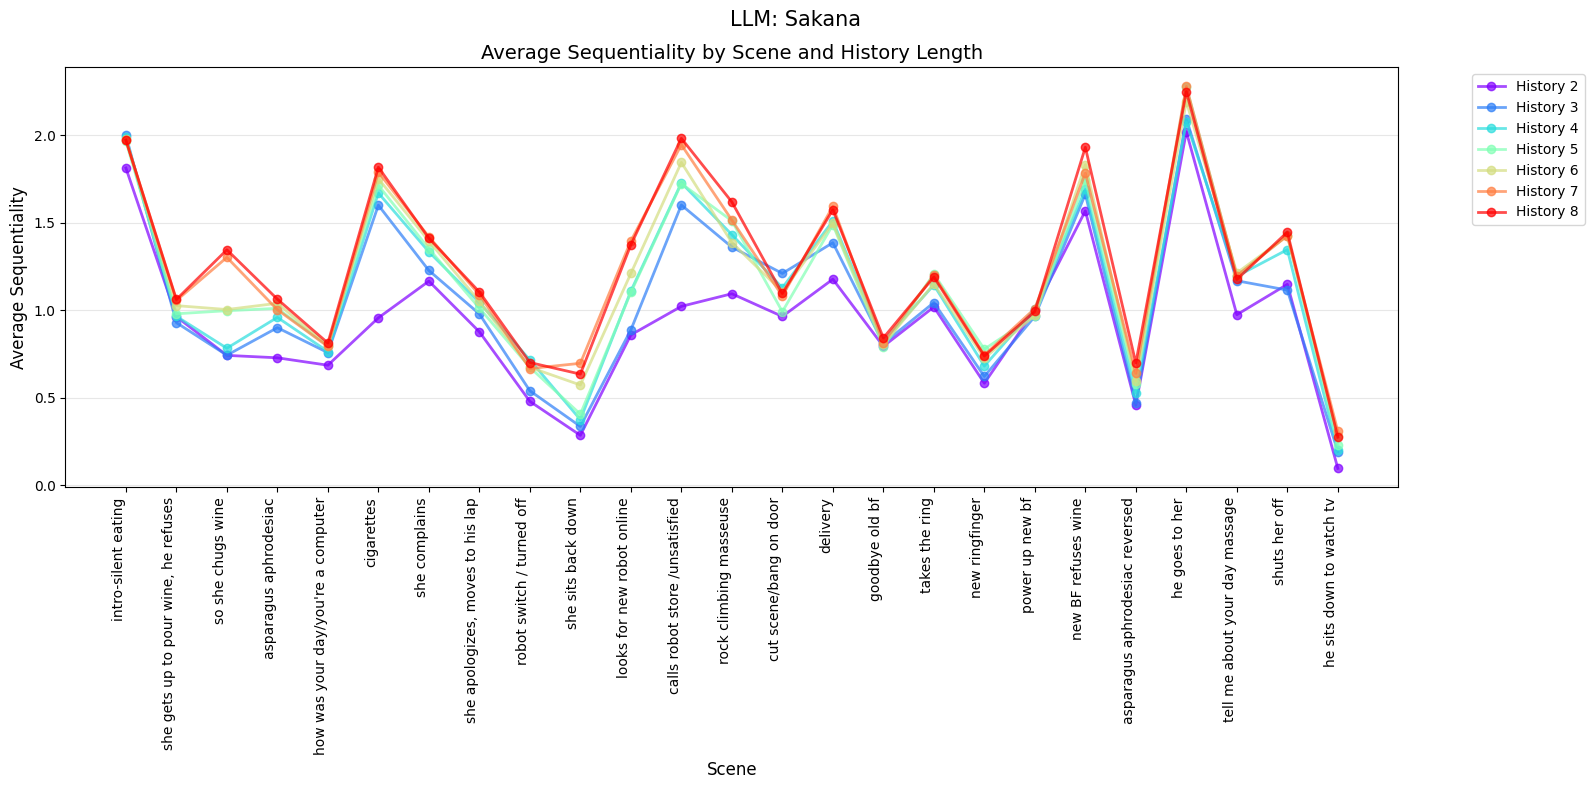

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# Define scene mappings
scene_mapping = {
    'intro-silent eating': list(range(2, 8)),
    'she gets up to pour wine, he refuses': list(range(8, 11)),
    'so she chugs wine': list(range(11, 15)),
    'asparagus aphrodesiac': list(range(15, 21)),
    'how was your day/you\'re a computer': list(range(21, 24)),
    'cigarettes': list(range(24, 30)),
    'she complains': list(range(30, 36)),
    'she apologizes, moves to his lap': list(range(36, 40)),
    'robot switch / turned off': list(range(40, 44)),
    'she sits back down': list(range(44, 46)),
    'looks for new robot online': list(range(46, 52)),
    'calls robot store /unsatisfied': list(range(52, 55)),
    'rock climbing masseuse': list(range(55, 60)),
    'cut scene/bang on door': [60],
    'delivery': list(range(61, 66)),
    'goodbye old bf': list(range(66, 70)),
    'takes the ring': [70],
    'new ringfinger': [71],
    'power up new bf': list(range(72, 75)),
    'new BF refuses wine': list(range(75, 78)),
    'asparagus aphrodesiac reversed': list(range(78, 83)),
    'he goes to her': [83],
    'tell me about your day massage': list(range(84, 90)),
    'shuts her off': list(range(90, 93)),
    'he sits down to watch tv': list(range(93, 95))
}

# Read the data
df = pd.read_csv('outputs/sakana/film-fest.csv')
df = df[df.iloc[:, 0].between(1, 7)]
df['seq_list'] = df.iloc[:, 2].apply(ast.literal_eval)

# Compute averages for each scene
scene_names = list(scene_mapping.keys())
colors = plt.cm.rainbow(np.linspace(0, 1, 7))

llm2_scene_avgs = []

plt.figure(figsize=(16, 8))

for hist_idx, (_, row) in enumerate(df.iterrows()):
    seq_list = row['seq_list']
    scene_avgs = []
    
    for scene_name in scene_names:
        sentence_indices = scene_mapping[scene_name]
        values = [seq_list[i] for i in sentence_indices if i < len(seq_list)]
        scene_avgs.append(np.mean(values) if values else 0)
    
    llm2_scene_avgs.append(scene_avgs)
    
    plt.plot(range(len(scene_names)), scene_avgs, 
             color=colors[hist_idx], label=f'History {hist_idx+2}', 
             marker='o', alpha=0.7, linewidth=2)

plt.xlabel('Scene', fontsize=12)
plt.ylabel('Average Sequentiality', fontsize=12)
plt.title('Average Sequentiality by Scene and History Length', fontsize=14)
plt.suptitle('LLM: Sakana', fontsize=15)
plt.xticks(range(len(scene_names)), scene_names, rotation=90, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# Define scene mappings
scene_mapping = {
    'intro-silent eating': list(range(2, 8)),
    'she gets up to pour wine, he refuses': list(range(8, 11)),
    'so she chugs wine': list(range(11, 15)),
    'asparagus aphrodesiac': list(range(15, 21)),
    'how was your day/you\'re a computer': list(range(21, 24)),
    'cigarettes': list(range(24, 30)),
    'she complains': list(range(30, 36)),
    'she apologizes, moves to his lap': list(range(36, 40)),
    'robot switch / turned off': list(range(40, 44)),
    'she sits back down': list(range(44, 46)),
    'looks for new robot online': list(range(46, 52)),
    'calls robot store /unsatisfied': list(range(52, 55)),
    'rock climbing masseuse': list(range(55, 60)),
    'cut scene/bang on door': [60],
    'delivery': list(range(61, 66)),
    'goodbye old bf': list(range(66, 70)),
    'takes the ring': [70],
    'new ringfinger': [71],
    'power up new bf': list(range(72, 75)),
    'new BF refuses wine': list(range(75, 78)),
    'asparagus aphrodesiac reversed': list(range(78, 83)),
    'he goes to her': [83],
    'tell me about your day massage': list(range(84, 90)),
    'shuts her off': list(range(90, 93)),
    'he sits down to watch tv': list(range(93, 95))
}

# Read the data
df = pd.read_csv('outputs/sakana/film-fest-use.csv')

import pandas as pd
import numpy as np
import ast

# Parse only the list columns (columns 3 and 4, which are mislabeled)
df['contextual_seq'] = df['sentence_contextual_sequentialities'].apply(ast.literal_eval)
df['topic_seq'] = df['sentence_topic_sequentialities'].apply(ast.literal_eval)

# Calculate average of contextual and topic sequentialities for each sentence
df['avg_seq'] = df.apply(lambda row: [
    (ctx + top) / 2 
    for ctx, top in zip(row['contextual_seq'], row['topic_seq'])
], axis=1)

# Print the result
print("Average sequentiality per sentence (first row):")
print(df['avg_seq'].iloc[0])
print(f"\nNumber of sentences: {len(df['avg_seq'].iloc[0])}")

Average sequentiality per sentence (first row):
[0.12177462, 0.12108109, 0.078953555, 0.1209943245, 0.166135915, 0.26876268, 0.257714449, 0.18355561320000002, 0.152136177, 0.3176508895, 0.241092385, 0.097041322, 0.093416315, 0.16326290000000002, 0.130772101, 0.19242117, 0.1185516545, 0.050461702000000004, 0.106049647, 0.180399264, 0.12179812899999999, 0.139839044, 0.190322194, 0.296738648, 0.320518799, 0.157747156, -0.0160424295, -0.0074930710000000005, 0.2473577325, 0.295036071, 0.07324844850000001, 0.0298849605, 0.20564955485, 0.199196745, 0.085414962, 0.18672001, 0.2227264, 0.15467218700000002, 0.25290499, 0.15844128175, 0.09839908950000001, 0.1346454675, 0.12395722749999999, 0.097071194, 0.14111952, 0.21805969349999998, 0.247556956, 0.2030952535, 0.018956554, 0.040217545, 0.12247471, 0.144835465, 0.278617715, 0.1121519425, 0.023727265, 0.031636092000000005, 0.018176372, 0.09639916500000001, 0.02271178665, 0.0303885905, -0.014642404500000001, 0.17737752499999998, -0.0011780920000000

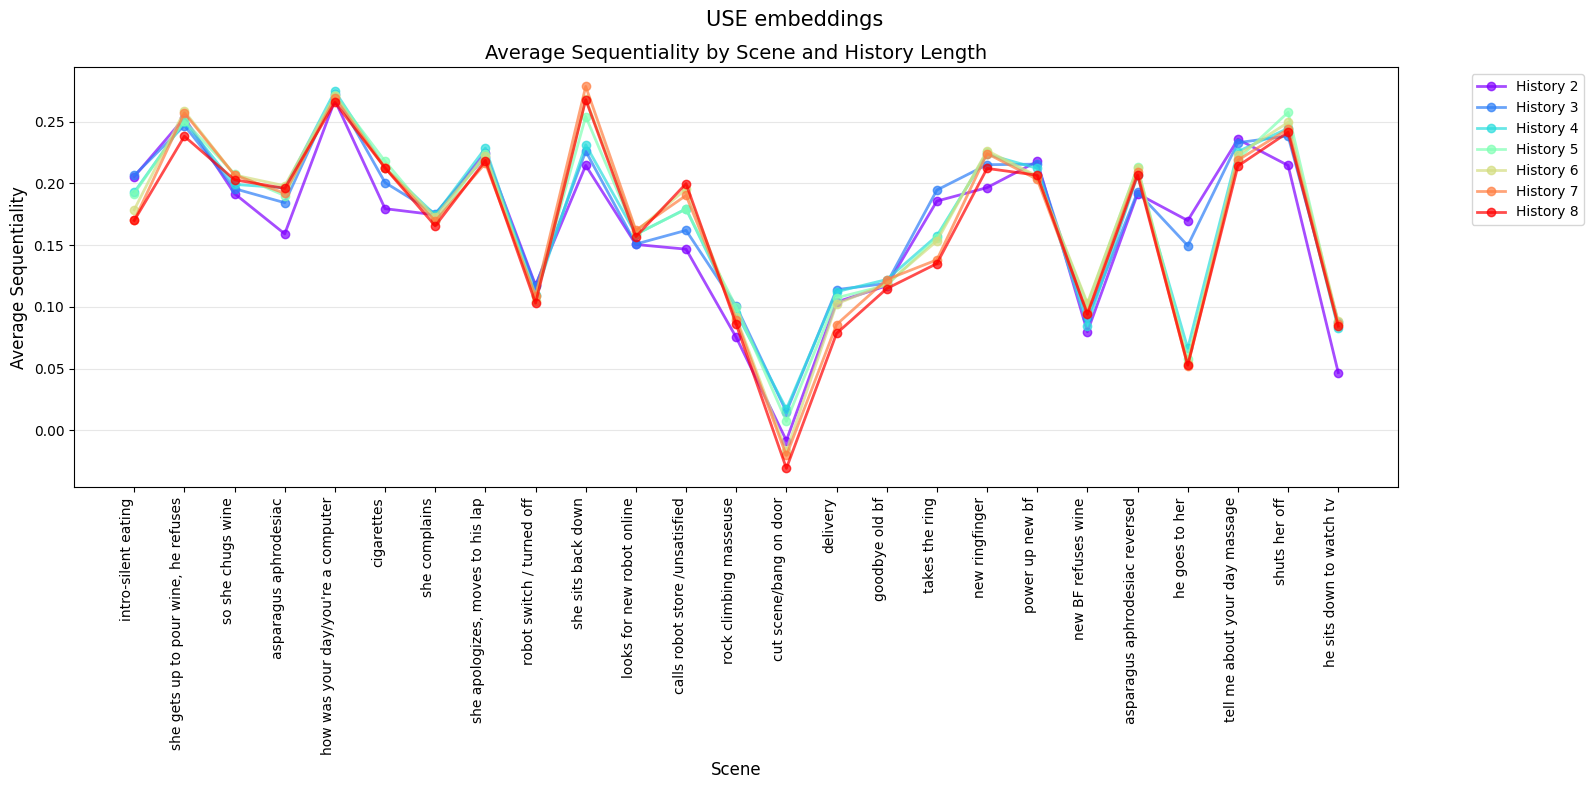

In [55]:
df = df[df.iloc[:, 0].between(1, 7)]

# Parse contextual and topic sequences, then compute average
df['contextual_seq'] = df['sentence_contextual_sequentialities'].apply(ast.literal_eval)
df['topic_seq'] = df['sentence_topic_sequentialities'].apply(ast.literal_eval)
df['avg_seq'] = df.apply(lambda row: [
    (ctx + top) / 2 
    for ctx, top in zip(row['contextual_seq'], row['topic_seq'])
], axis=1)

# Compute averages for each scene
scene_names = list(scene_mapping.keys())
colors = plt.cm.rainbow(np.linspace(0, 1, 7))

plt.figure(figsize=(16, 8))


use_scene_avgs = []

for hist_idx, (_, row) in enumerate(df.iterrows()):
    seq_list = row['avg_seq']
    scene_avgs = []
    
    for scene_name in scene_names:
        sentence_indices = scene_mapping[scene_name]
        values = [seq_list[i] for i in sentence_indices if i < len(seq_list)]
        scene_avgs.append(np.mean(values) if values else 0)
    
    use_scene_avgs.append(scene_avgs)
    
    plt.plot(range(len(scene_names)), scene_avgs, 
             color=colors[hist_idx], label=f'History {hist_idx+2}', 
             marker='o', alpha=0.7, linewidth=2)

plt.xlabel('Scene', fontsize=12)
plt.ylabel('Average Sequentiality', fontsize=12)
plt.title('Average Sequentiality by Scene and History Length', fontsize=14)
plt.suptitle('USE embeddings', fontsize=15)
plt.xticks(range(len(scene_names)), scene_names, rotation=90, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

History 1 slope: -0.751
History 2 slope: -1.544
History 3 slope: -2.916
History 4 slope: -2.181
History 5 slope: -2.728
History 6 slope: -3.559
History 7 slope: -2.973


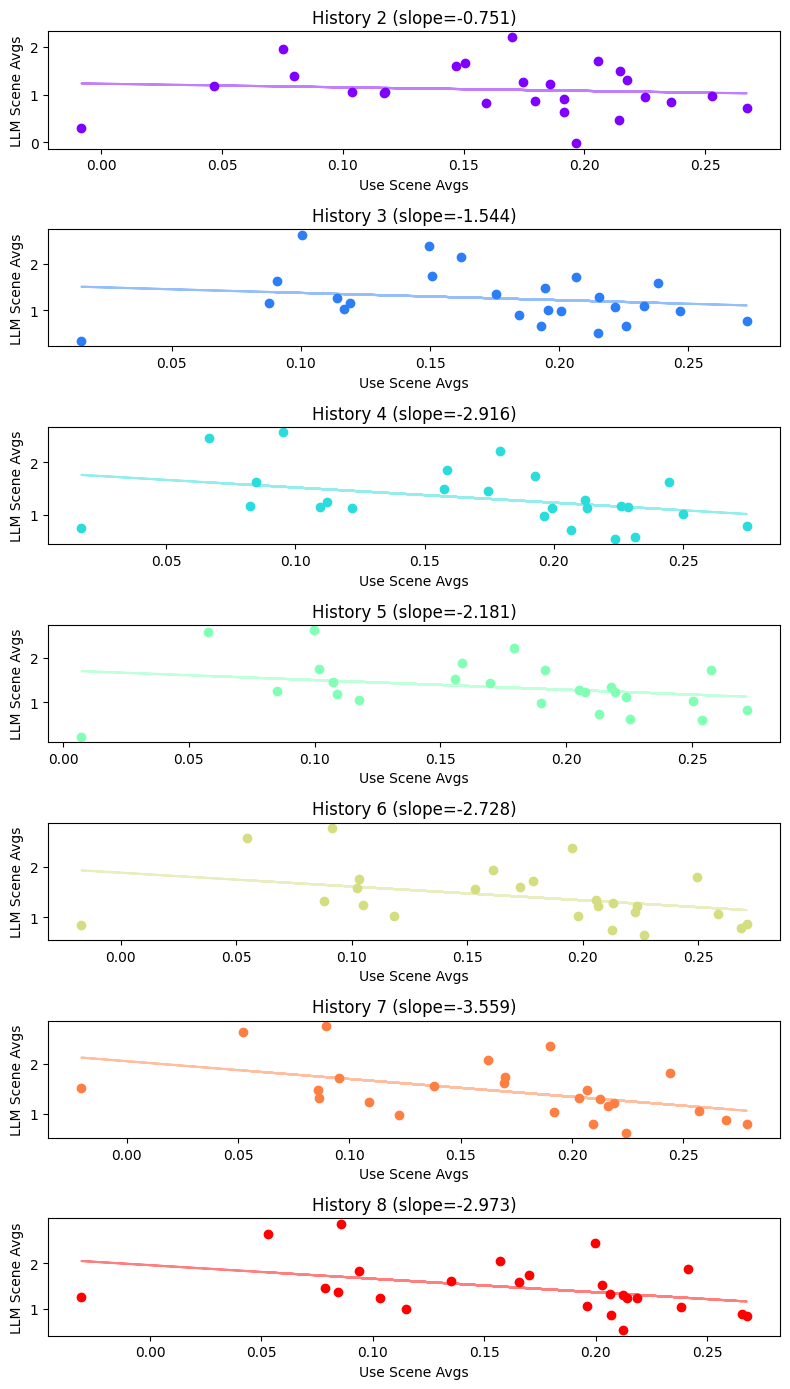

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

use_scene_avgs = np.array(use_scene_avgs)
llm_scene_avgs = np.array(llm1_scene_avgs)

fig, axes = plt.subplots(len(use_scene_avgs), 1, figsize=(8, 2*len(use_scene_avgs)))

slopes = []

for i, (ax, color) in enumerate(zip(axes, plt.cm.rainbow(np.linspace(0, 1, len(use_scene_avgs))))):
    ax.scatter(use_scene_avgs[i], llm_scene_avgs[i], color=color)
    m, b = np.polyfit(use_scene_avgs[i], llm_scene_avgs[i], 1)

    slopes.append(m)

    ax.plot(use_scene_avgs[i], m*use_scene_avgs[i] + b, '-', color=color, alpha=0.5)
    ax.set_title(f'History {i+2} (slope={m:.3f})')
    ax.set_xlabel('Use Scene Avgs')
    ax.set_ylabel('LLM Scene Avgs')
    print(f'History {i+1} slope: {m:.3f}')
plt.tight_layout()
plt.show()

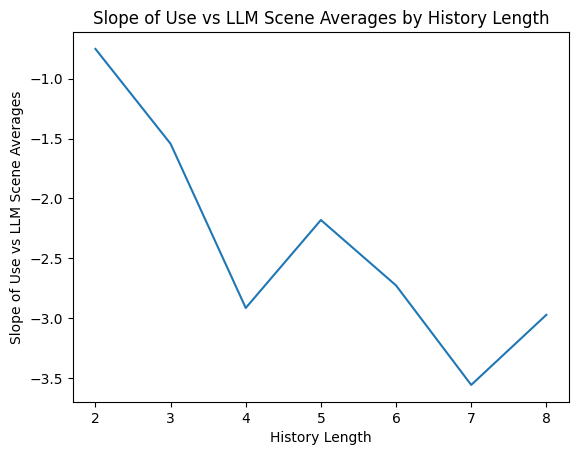

In [43]:
plt.plot(range(2, 9), slopes,)
plt.xlabel('History Length')
plt.ylabel('Slope of Use vs LLM Scene Averages')
plt.title('Slope of Use vs LLM Scene Averages by History Length')
plt.xticks(range(2, 9))
plt.show()

History 1 slope: 0.754
History 2 slope: 0.716
History 3 slope: 0.802
History 4 slope: 0.861
History 5 slope: 0.823
History 6 slope: 0.846
History 7 slope: 0.855


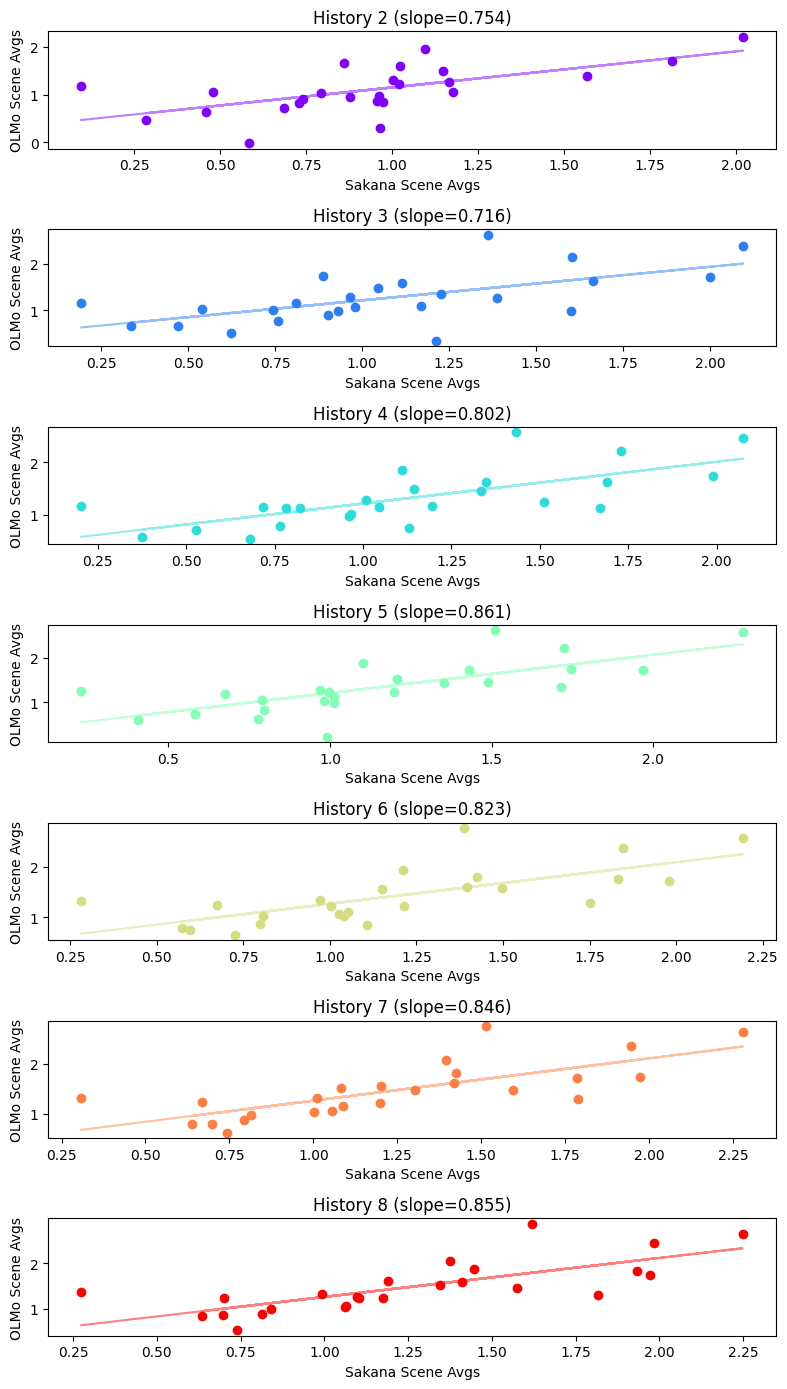

In [59]:
import matplotlib.pyplot as plt
import numpy as np

use_scene_avgs = np.array(llm2_scene_avgs)
llm_scene_avgs = np.array(llm1_scene_avgs)

fig, axes = plt.subplots(len(use_scene_avgs), 1, figsize=(8, 2*len(use_scene_avgs)))

slopes = []

for i, (ax, color) in enumerate(zip(axes, plt.cm.rainbow(np.linspace(0, 1, len(use_scene_avgs))))):
    ax.scatter(use_scene_avgs[i], llm_scene_avgs[i], color=color)
    m, b = np.polyfit(use_scene_avgs[i], llm_scene_avgs[i], 1)

    slopes.append(m)

    ax.plot(use_scene_avgs[i], m*use_scene_avgs[i] + b, '-', color=color, alpha=0.5)
    ax.set_title(f'History {i+2} (slope={m:.3f})')
    ax.set_xlabel('Sakana Scene Avgs')
    ax.set_ylabel('OLMo Scene Avgs')
    print(f'History {i+1} slope: {m:.3f}')
plt.tight_layout()
plt.show()

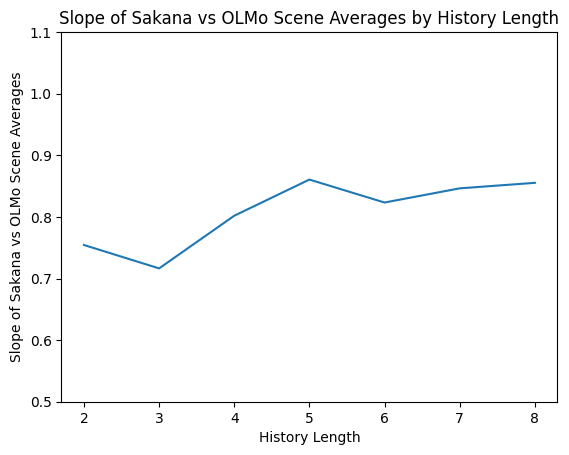

In [63]:
plt.plot(range(2, 9), slopes,)
plt.xlabel('History Length')
plt.ylabel('Slope of Sakana vs OLMo Scene Averages')
plt.title('Slope of Sakana vs OLMo Scene Averages by History Length')
plt.xticks(range(2, 9))
plt.yticks(np.arange(0.5, 1.1, 0.1))
plt.show()

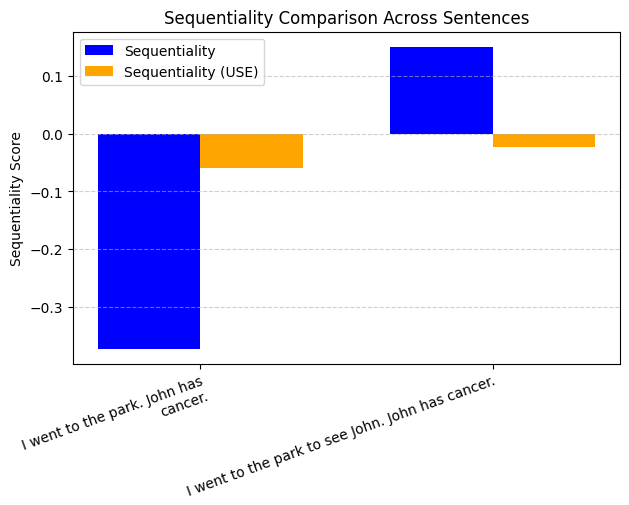

In [66]:
import matplotlib.pyplot as plt

# Data
labels = [
    "I went to the park. John has cancer.",
    "I went to the park to see John. John has cancer."
]
values = [-0.3725260416666667, 0.15108235677083331]
values_use = [-0.05903811752796173, -0.022637546062469482]

# Bar width and positions
x = range(len(labels))
bar_width = 0.35

# Plot bars
plt.bar([i - bar_width/2 for i in x], values, width=bar_width, color='blue', label='Sequentiality')
plt.bar([i + bar_width/2 for i in x], values_use, width=bar_width, color='orange', label='Sequentiality (USE)')

# Labels and formatting
plt.xticks(x, labels, rotation=20, ha='right', wrap=True)
plt.ylabel('Sequentiality Score')
plt.title('Sequentiality Comparison Across Sentences')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

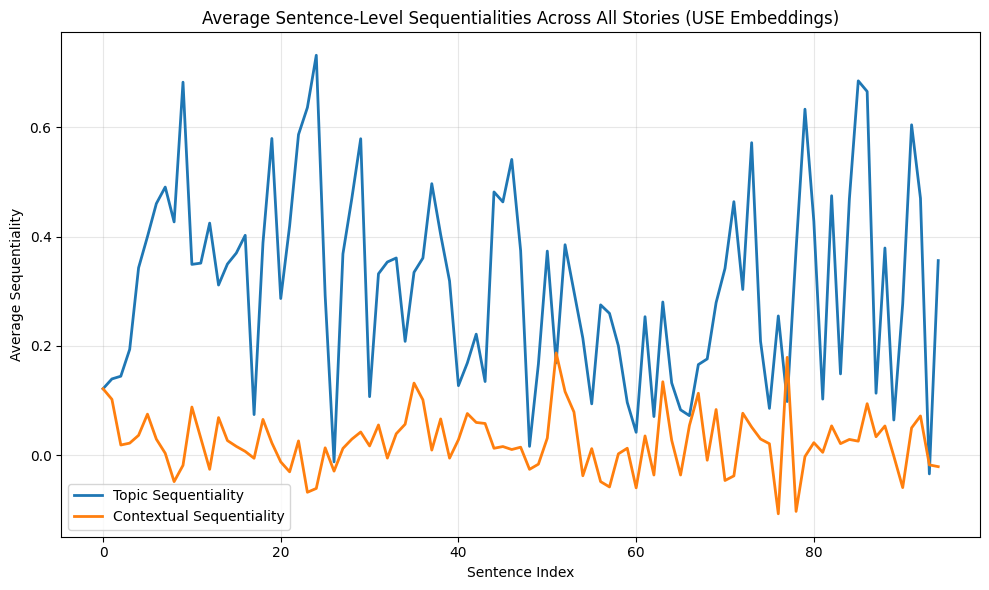

In [71]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("./outputs/sakana/film-fest-use.csv")

# These columns contain stringified lists
topic_col = "sentence_topic_sequentialities"
context_col = "sentence_contextual_sequentialities"

# Parse the stringified lists into Python lists
df[topic_col] = df[topic_col].apply(ast.literal_eval)
df[context_col] = df[context_col].apply(ast.literal_eval)

# Find the maximum sentence length across all rows
max_len = max(df[topic_col].apply(len).max(), df[context_col].apply(len).max())

# Pad all lists to the same length with NaNs
def pad_to_len(lst, length):
    return lst + [np.nan] * (length - len(lst))

df[topic_col] = df[topic_col].apply(lambda x: pad_to_len(x, max_len))
df[context_col] = df[context_col].apply(lambda x: pad_to_len(x, max_len))

# Convert lists into numpy arrays for averaging
topic_matrix = np.vstack(df[topic_col].values)
context_matrix = np.vstack(df[context_col].values)

# Compute the average across all rows (ignoring NaNs)
avg_topic = np.nanmean(topic_matrix, axis=0)
avg_context = np.nanmean(context_matrix, axis=0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(avg_topic, label="Topic Sequentiality", linewidth=2)
plt.plot(avg_context, label="Contextual Sequentiality", linewidth=2)
plt.xlabel("Sentence Index")
plt.ylabel("Average Sequentiality")
plt.title("Average Sentence-Level Sequentialities Across All Stories (USE Embeddings)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
